In [ ]:
from google.colab import drive
drive.mount('/content/drive')
resources = "drive/MyDrive/Colab Notebooks/RISORSE"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install d2l

First i need to import all necessary libraries

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
d2l.use_svg_display()
import os
import random
import shutil
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

Charging the dataset and printing all classes with their respective dimensions

In [ ]:
dataset_path = "/content/drive/My Drive/proj_dataset"
print("Path to dataset files:", dataset_path)
class_ct = {}
for c_name in os.listdir(dataset_path):
    c_path = os.path.join(dataset_path, c_name)
    if os.path.isdir(c_path):
        class_ct[c_name] = len(os.listdir(c_path))

print(class_ct)

Path to dataset files: /content/drive/My Drive/proj_dataset
{'fencing': 626, 'motogp': 669, 'baseball': 726, 'basketball': 485, 'formula1': 677, 'tennis': 707, 'ice_hockey': 701, 'football': 790, 'swimming': 681, 'boxing': 695, 'wrestling': 599, 'volleyball': 699}


Now that the dataset is correctly charged, check if all the values are usable and not corrupted.

In [ ]:
def check_dataset_integrity(dataset_path):

    problematic_files = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Attempt to open the file as an image
                with Image.open(file_path) as img:
                    img.verify()  # Verify the file is an image
            except Exception as e:
                problematic_files.append(file_path)
                print(f"File {file_path} is problematic: {e}")
    return problematic_files

# Run the check
issues = check_dataset_integrity(dataset_path)
if not issues:
    print("All files are valid.")
else:
    print(f"Found {len(issues)} problematic files.")

All files are valid.


Since some not usable data were found, let's remove them from the dataset

In [ ]:
def remove_problematic_files(problematic_files):
    for file_path in problematic_files:
        try:
            os.remove(file_path)
            print(f"Removed: {file_path}")
        except Exception as e:
            print(f"Failed to remove {file_path}: {e}")

# Remove problematic files
remove_problematic_files(issues)

My analysis will now focus on 250 images per class randomly chosen

In [ ]:
# Percorso al nuovo dataset ridimensionato
resized_dataset_path = "/content/dataset_resized"
os.makedirs(resized_dataset_path, exist_ok=True)

# Numero di immagini per classe
target_count = 250

# Itera su ciascuna classe
for c_name in os.listdir(dataset_path):
    c_path = os.path.join(dataset_path, c_name)

    # Controlla se è una directory
    if os.path.isdir(c_path):
        # Crea la cartella per la classe nel dataset ridimensionato
        new_c_path = os.path.join(resized_dataset_path, c_name)
        os.makedirs(new_c_path, exist_ok=True)

        # Ottieni una lista di immagini nella classe
        images = os.listdir(c_path)
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Seleziona casualmente target_count immagini
        selected_images = random.sample(images, min(len(images), target_count))

        # Copia le immagini selezionate nella nuova directory
        for img in selected_images:
            src_path = os.path.join(c_path, img)
            dst_path = os.path.join(new_c_path, img)
            shutil.copy(src_path, dst_path)

        print(f"Classe {c_name}: {len(selected_images)} immagini copiate.")


Classe fencing: 250 immagini copiate.
Classe motogp: 250 immagini copiate.
Classe baseball: 250 immagini copiate.
Classe basketball: 250 immagini copiate.
Classe formula1: 250 immagini copiate.
Classe tennis: 250 immagini copiate.
Classe ice_hockey: 250 immagini copiate.
Classe football: 250 immagini copiate.
Classe swimming: 250 immagini copiate.
Classe boxing: 250 immagini copiate.
Classe wrestling: 250 immagini copiate.
Classe volleyball: 250 immagini copiate.


Displaying 3 images per class

Classe: tennis


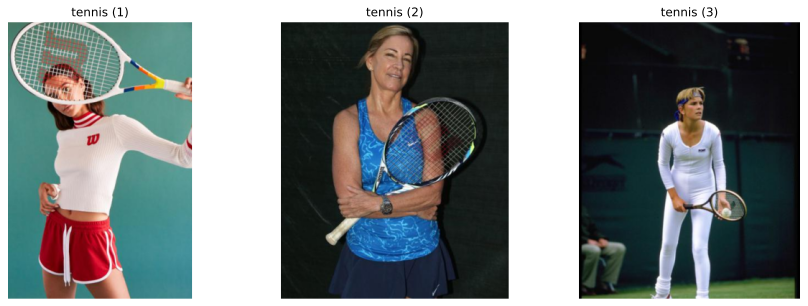

Classe: football


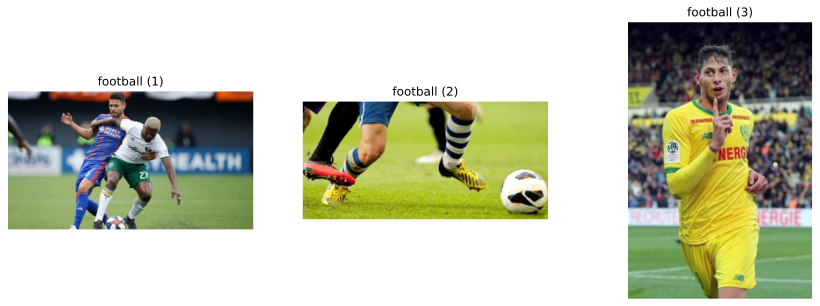

Classe: ice_hockey


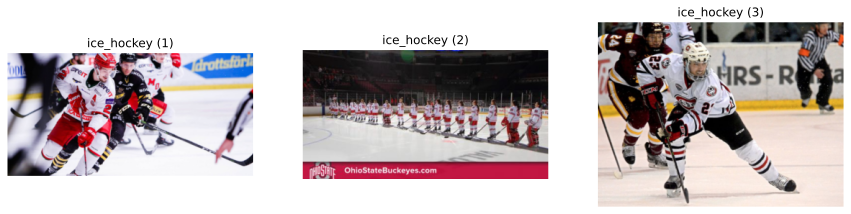

Classe: basketball


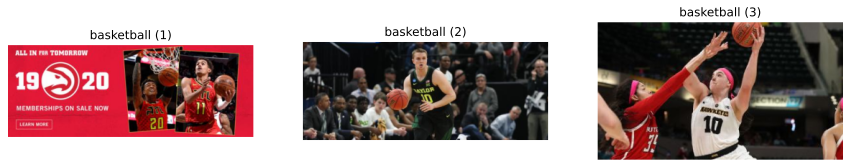

Classe: fencing


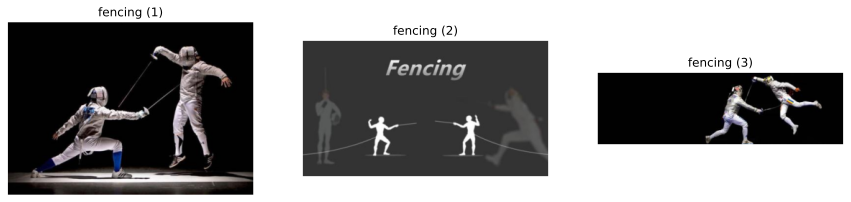

Classe: swimming


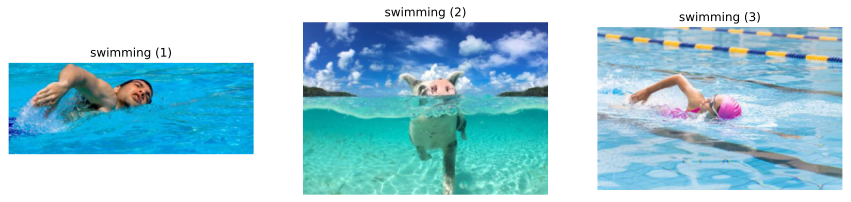

Classe: volleyball


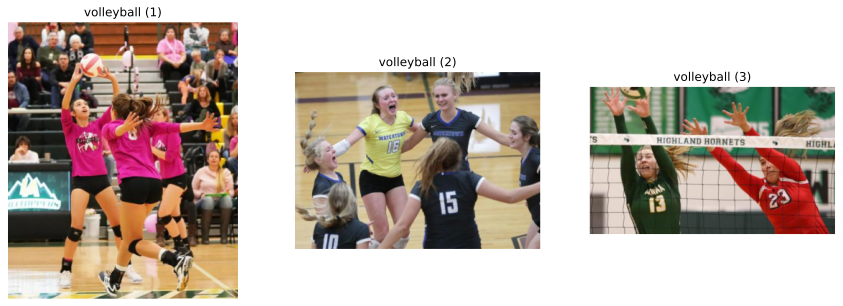

Classe: baseball


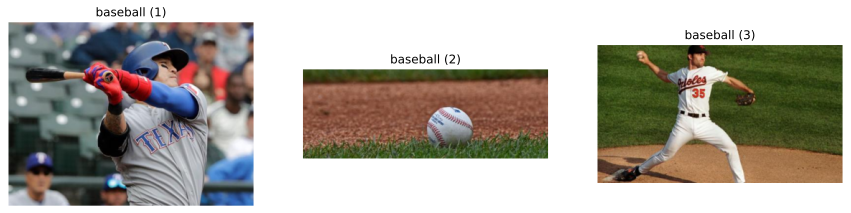

Classe: motogp


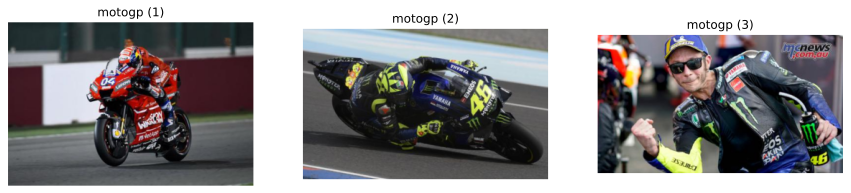

Classe: boxing


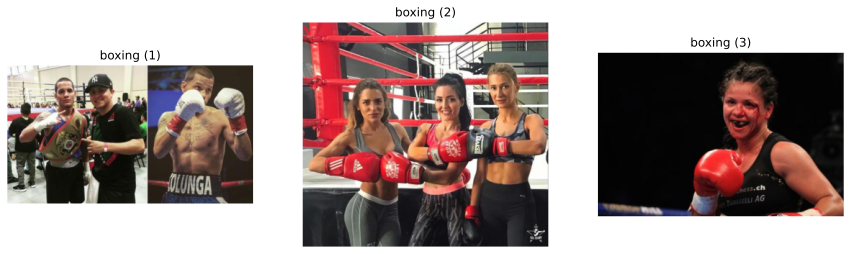

Classe: formula1


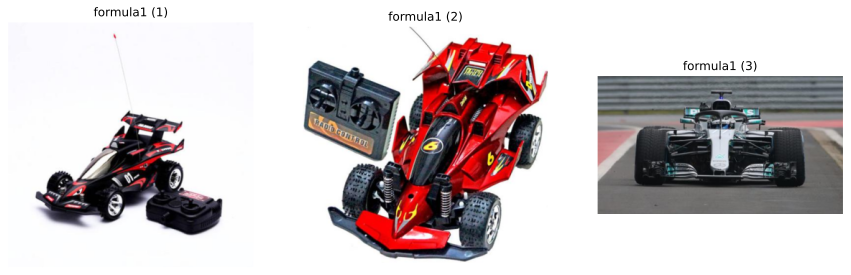

Classe: wrestling


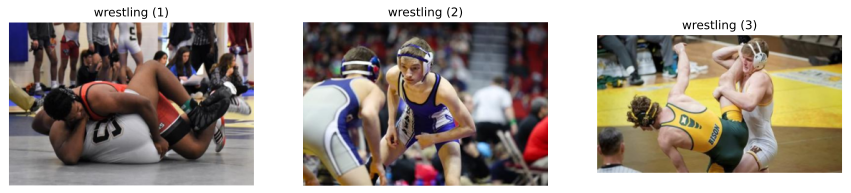

In [ ]:
def display_sample_images(data_folder, num_images=3):

    # Ottieni le classi come sottodirectory del dataset
    classes = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]

    for c_name in classes:
        c_path = os.path.join(data_folder, c_name)
        images = [img for img in os.listdir(c_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Seleziona immagini casuali dalla classe
        sample_images = random.sample(images, min(num_images, len(images)))

        print(f"Classe: {c_name}")
        plt.figure(figsize=(15, 5))  # Dimensione della figura

        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(c_path, img_name)
            img = Image.open(img_path)

            plt.subplot(1, num_images, i + 1)  # Organizza le immagini su una riga
            plt.imshow(img)
            plt.title(f"{c_name} ({i + 1})")  # Aggiungi titolo con il nome della classe
            plt.axis('off')  # Nascondi assi

        plt.show()

# Visualizza un campione di immagini (3 immagini per classe)
display_sample_images(resized_dataset_path, num_images=3)


Looking at the original dimension of the images

In [ ]:
def check_image_sizes(main_folder):
    size_counts = {}
    for c_name in os.listdir(main_folder):
        c_path = os.path.join(main_folder, c_name)
        if os.path.isdir(c_path):
            for img_name in os.listdir(c_path):
                img_path = os.path.join(c_path, img_name)

                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        with Image.open(img_path) as img:
                            size = img.size
                            if size in size_counts:
                                size_counts[size] += 1
                            else:
                                size_counts[size] = 1
                    except Exception as e:
                        print(f"Errore nell'aprire il file {img_path}: {e}")

    for size, count in size_counts.items():
        print(f"Risolution {size}: {count} images")

check_image_sizes(resized_dataset_path)

Risolution (500, 280): 57 images
Risolution (500, 262): 45 images
Risolution (480, 270): 22 images
Risolution (500, 333): 479 images
Risolution (500, 400): 15 images
Risolution (500, 281): 437 images
Risolution (480, 237): 1 images
Risolution (386, 500): 3 images
Risolution (360, 240): 5 images
Risolution (500, 375): 136 images
Risolution (500, 214): 3 images
Risolution (500, 294): 4 images
Risolution (500, 279): 4 images
Risolution (500, 357): 8 images
Risolution (500, 332): 96 images
Risolution (500, 362): 2 images
Risolution (500, 363): 4 images
Risolution (359, 240): 1 images
Risolution (400, 267): 11 images
Risolution (400, 282): 2 images
Risolution (500, 249): 3 images
Risolution (480, 300): 11 images
Risolution (500, 306): 4 images
Risolution (300, 210): 1 images
Risolution (500, 337): 5 images
Risolution (381, 500): 1 images
Risolution (500, 278): 11 images
Risolution (500, 352): 7 images
Risolution (500, 324): 6 images
Risolution (465, 262): 1 images
Risolution (500, 213): 1 i

I chose to standardize the size of all images and resize them to 500x333 because it was the more common size among the dataset and also most of the images have similar dimension; then i converted all the images in PyTorch tensors, loaded the transformed dataset in batches (64 per batch), computed the mean across height, width and batch for each channel.
Num_img stores the number of images processed. Finally i computed the global mean and st. dev by dividing the accumulated sums by the total number of images.

In [ ]:
# Crea una trasformazione per il dataset
transform = transforms.Compose([
    transforms.Resize((500, 333)),
    transforms.ToTensor()
])

# Usa il dataset ImageFolder di PyTorch (o uno personalizzato)
dataset = datasets.ImageFolder(resized_dataset_path, transform=transform)

# Crea un DataLoader per caricare il dataset in batch
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Variabili per sommare media e deviazione standard
mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
num_img = 0

# Calcola media e deviazione standard per batch
for images, _ in data_loader:
    # Somma la media e deviazione standard per batch
    mean_sum += images.mean(dim=[0, 2, 3]) * images.size(0)
    std_sum += images.std(dim=[0, 2, 3]) * images.size(0)
    num_img += images.size(0)

# Calcola la media e deviazione standard globali
mean = mean_sum / num_img
std = std_sum / num_img

# Stampa i risultati
print(f"Mean: {mean}")
print(f"Standard deviation:{std}")

Mean: tensor([0.4412, 0.4333, 0.4158])
Standard deviation:tensor([0.2946, 0.2748, 0.2793])


Now i can proceed with the data augumentation by applying randomly some transormations to the images (rotations, flips, color changes and blurs) and standardizing images using the computed mean and st.dev.

In [ ]:
mean=torch.tensor([0.4403, 0.4332, 0.4148])
stdev=torch.tensor([0.2959, 0.2754, 0.2801])
data_augmentation = transforms.Compose([
    transforms.Resize((500, 333)),
    transforms.RandomApply([transforms.RandomRotation(degrees=30)], p=0.5),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.5),
    transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.2, hue=0.1)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdev),
])

test_augmentation = transforms.Compose([
    transforms.Resize((500, 333)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stdev)
])

I decided now to create a new class named SportsDataset which add functionality for oversampling in our dataset in order to improve future training robustness. I defined the new len function to redefine the total number of samples in the dataset with oversample, while the function getitem retrieves a sample from the dataset and applies the desired transformations to io, then we return the transformed image with its label.

In [ ]:
class SportsDataset(data.Dataset):
    def __init__(self, dataset, transform=None, oversample=5):
        self.dataset = dataset
        self.transform = transform
        self.oversample = oversample

    def __len__ (self):
        return len(self.dataset) * self.oversample

    def __getitem__(self, idx):
        # Use modulo to get the original image
        original_idx = idx % len(self.dataset)
        image, label = self.dataset[original_idx]

        if not isinstance(image, torch.Tensor) and self.transform:
            image = self.transform(image) # Apply transforms only if not already a tensor

        return image, label

Now i created a new dataset with data augumentation applied.

In [ ]:
new_dataset = datasets.ImageFolder(root=resized_dataset_path, transform=data_augmentation)

I want to check if the data augumentation was correctly applied so i denormalized the images and displayed a grid of 30 images from the dataset

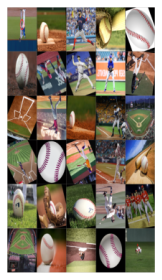

In [ ]:
def imshow(img, mean, std):
    # Converti mean e std in tensori solo se sono liste
    mean = torch.tensor(mean)[:, None, None] if isinstance(mean, list) else mean
    std = torch.tensor(std)[:, None, None] if isinstance(std, list) else std

    # Denormalizzazione
    img = img * std + mean
    img = torch.clamp(img, 0, 1)  # Clipping dei valori per rimanere nel range [0, 1]

    # Converti in formato NumPy e cambia la disposizione degli assi
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Valori di mean e std per la normalizzazione
mean = [0.4418, 0.4327, 0.4148]
stdev = [0.2947, 0.2738, 0.2784]

# Ottieni un batch di immagini da `new_dataset`
images = [new_dataset[i][0] for i in range(30)]  # Modifica `new_dataset` come necessario

# Crea una griglia di immagini
grid_img = torchvision.utils.make_grid(images, nrow=5)

# Visualizza la griglia
imshow(grid_img, mean, stdev)


I proceeded to define a custom residual block (class Res) for use in deep convolutional neural networks, inspired by ResNet (Residual Networks). The purpose of this block is to enable deeper network architectures by introducing skip connections that help mitigate the vanishing gradient problem.

In [ ]:
class Res(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1, dropout_prob=0.35):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))

        Y = self.bn2(self.conv2(Y))

        if self.conv3:
            X = self.conv3(X)

        Y += X

        Y = self.dropout(Y)

        return F.relu(Y)

X = torch.rand(4, 3, 64, 64)
res_block = Res(3, 3, use_1x1conv=True)

output = res_block(X)
print(output.shape)

torch.Size([4, 3, 64, 64])


I initialized (using Kaming normal initialization) the weights of neural network layers to improve training efficiency and model performance.

In [ ]:
def initialize_weights(w):
    if isinstance(w, nn.Conv2d):
        nn.init.kaiming_normal_(w.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(w, nn.BatchNorm2d):
        nn.init.constant_(w.weight, 1)
        nn.init.constant_(w.bias, 0)

Now i defined a custom ResNet model in PyTorch, using the previously defined block Res and incorporating dropout for regularization and overfitting prevention.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=12, dropout_prob=0.35):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, dropout_prob=dropout_prob)
        self.layer2 = self.make_layer(64, 128, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.make_layer(128, 256, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.make_layer(256, 512, 2, stride=2, dropout_prob=dropout_prob)

        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1, dropout_prob=0.35):
        layers = []
        layers.append(Res(in_channels, out_channels, strides=stride, use_1x1conv=True, dropout_prob=dropout_prob))
        for _ in range(1, num_blocks):
            layers.append(Res(out_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = ResNet(num_classes=12, dropout_prob=0.35)
model.apply(initialize_weights)
X = torch.randn(8, 3, 64, 64)
model(X)

tensor([[-6.8278e-01,  2.2645e+00,  2.9353e-01,  1.4289e+00,  3.5335e+00,
          6.6023e+00,  1.5359e+00,  1.3676e+00, -2.3661e+00, -1.8979e+00,
         -1.2911e+00,  1.3478e+00],
        [ 8.9925e-01,  5.2795e-01, -3.6453e+00,  4.1609e+00, -1.7302e+00,
         -8.4105e-01,  2.8616e-01,  4.4185e-01, -4.5194e-01, -2.0354e+00,
         -5.1778e-01, -1.0870e+00],
        [ 1.5222e+00, -1.8122e+00,  8.6437e-01,  2.2484e+00,  2.4458e+00,
         -3.0935e+00, -1.2988e-03,  1.9523e+00,  7.3005e-01,  1.1050e+00,
          1.2407e+00,  5.1863e-02],
        [ 2.1102e+00, -3.4646e+00,  5.7353e-01,  2.4013e+00,  4.7675e-01,
          1.4154e+00, -3.8498e+00,  2.9705e+00, -1.9848e+00, -1.7384e+00,
         -8.6274e-01, -1.6863e+00],
        [ 8.8643e-01, -1.8625e+00, -3.6290e-01,  5.4865e+00,  1.5143e+00,
         -8.4467e-01,  7.7445e-02, -2.8482e+00,  2.0947e-02, -1.3806e+00,
         -1.7294e-01,  5.2741e-01],
        [-9.8247e-01, -3.8939e+00,  1.9363e+00,  1.6138e+00,  2.7617e+00,
      

Let's see the dataset now

In [ ]:
new_dataset

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /content/dataset_resized
    StandardTransform
Transform: Compose(
               Resize(size=(500, 333), interpolation=bilinear, max_size=None, antialias=True)
               RandomApply(
               p=0.5
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
               RandomApply(
               p=0.5
               RandomHorizontalFlip(p=1.0)
           )
               RandomApply(
               p=0.5
               RandomVerticalFlip(p=1.0)
           )
               RandomApply(
               p=0.5
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.9, 1.1), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
           )
               RandomApply(
               p=0.5
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
           )
               ToTensor()
               Normalize(mean=tensor([0.4403, 0.4332, 0.4148]), std=tensor

Now i want to evaluate the accuracy of a neural network model on a dataset and to train the model, the accumulator tracks the number of corrected predictions and the total number of predictions, the first function returns the ratio (accuracy). The train function starts by initializing weights using the Xavier uniform initialization, Adam optimizer adjusts learning rates for each parameter. The program proceeds to compute validation accuracy after each epoch and saves the model if it improves, in the end the function saves the model with the best value.

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):

    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, val_iter, num_epochs, lr,
          device=d2l.try_gpu(), save_path="/content/drive/MyDrive/best_model.pth"):

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net = net.to(device) # MOVE the net to the GPU (if available)

    # Sostituito con Adam (learning rate 0,01)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    best_val_acc = 0
    timer, num_batches = d2l.Timer(), len(train_iter)
    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) # MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l.item() * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter, device)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(net.state_dict(), save_path)
        animator.add(epoch + 1, (None, None, val_acc))
        progress_bar.set_description(f'loss {train_l:.3f}, train acc {train_acc:.3f}, val acc {val_acc:.3f}, best val acc {best_val_acc:.3f}')
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'val acc {val_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


Check for GPU availability

In [ ]:
torch.cuda.is_available()

True

Now i split the dataset into training, validation and test subsets, incorporating reproducibility, data augmentation, and dataset statistics.
Since my dataset is made of 12 classes each with 250 images (total size=3000) so to have balance between training and evaluation, i decided to split the dataset with these proportions: train ->70%, test and validation set ->15% each. Train has size 10500 because of the oversampling performed earlier (2100 x 5).

In [ ]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

train_dataset, test_dataset = train_test_split(new_dataset, test_size=0.3, random_state=SEED)
test_dataset, val_dataset = train_test_split(test_dataset, test_size=0.5, random_state=SEED)
train_dataset = SportsDataset(train_dataset, transform=data_augmentation, oversample=5)
test_dataset = SportsDataset(test_dataset, transform=test_augmentation, oversample=1)
val_dataset = SportsDataset(val_dataset, transform=test_augmentation, oversample=1)
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
total_size = train_size + val_size + test_size


print(f"Training examples: {train_size}")
print(f"Validation examples: {val_size}")
print(f"Testing examples: {test_size}")

Training examples: 10500
Validation examples: 450
Testing examples: 450


I want to initialize DataLoaders for the training, validation, and test datasets, then print the shapes of the first batch of images and their corresponding labels from the training dataset.

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for images, labels in train_loader:
    print(f"Batch shape: {images.size()}")
    print(f"Labels: {labels}")
    break

Batch shape: torch.Size([16, 3, 500, 333])
Labels: tensor([ 9,  3,  6,  8, 11, 10,  0,  4,  5, 10,  1,  3,  6,  4,  0,  7])


Now i want inspect a batch (first 16 images) after preprocessing and augmentation, ensuring that the data augmentation pipeline is functioning as expected and that images are properly transformed.

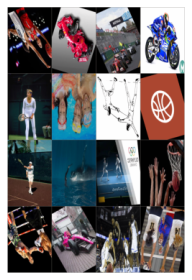

In [ ]:
images = next(iter(train_loader))[0][:16]
grid_img = torchvision.utils.make_grid(images, nrow=4)
imshow(grid_img, mean, stdev)

Let's the training process of my dataset using PyTorch, "lr" refers to the learning rate and specifies how much the model's weights are updated during training, num_epochs refers to the number of iterations of the training.

loss 0.446, train acc 0.849, val acc 0.520, best val acc 0.573: 100%|██████████| 35/35 [1:09:49<00:00, 119.69s/it]


loss 0.446, train acc 0.849, val acc 0.520
94.3 examples/sec on cuda


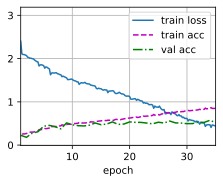

In [ ]:
# Learning rate and number of epochs
lr, num_epochs = 0.01, 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(num_classes=12, dropout_prob=0.35)
model = model.to(device)
train(model, train_loader, val_loader, num_epochs, lr, device)

Finally i want to generate a normalized confusion matrix to show the fraction of correct predictions for each class.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(num_classes=12, dropout_prob=0.35)
model.eval()
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth', map_location=device, weights_only=True))
model = model.to(device)

Y_true = []
Y_pred = []
for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    y_hat = model(X)
    Y_pred.extend(torch.argmax(y_hat, dim=1).cpu().numpy())
    Y_true.extend(y.cpu().numpy())

accuracy:  0.5644444444444444


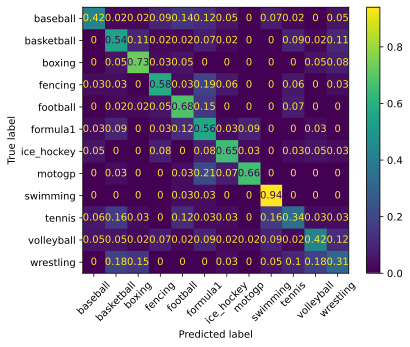

In [ ]:
acc = accuracy_score(Y_true, Y_pred)
conf_mat = confusion_matrix(Y_true, Y_pred, normalize='true') #For Normalized Confusion Matrix
#conf_mat = confusion_matrix(Y_true, Y_pred) #For Unnormalized Confusion Matrix
report = classification_report(Y_true, Y_pred, target_names=new_dataset.classes)
conf_mat = np.round(conf_mat, 2)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=new_dataset.classes)
disp.plot(xticks_rotation=45)
print("accuracy: ", acc)

The confusion matrix displayed reveals the following observations about the model's performance:

    Class-Level Insights:
        The model performs exceptionally well for classes "swimming" and "boxing" achieving true positive rates of 0.94 and 0.73 respectively. This indicates that the model has learned to recognize those class effectively.
        For what concerns classes such as "basketball", "fencing", "football", "formula 1", "ice hockey" and "motogp" the model performs well, achieving true positive rates between 0.5 and 0.7.
        The model instead struggles with classes "baseball", "tennis", "volleyball" and "wrestling" where the true positive rate stands under 0.5.

    Confusion and Misclassifications:
        Several sports exhibit confusion with each other. This could be due to similar feature representations in the dataset or insufficient diversity in training data for these classes.
        Classes with higher confusion indicate that the model might be relying on shared features (e.g., uniforms or environments) that are not distinctive enough.

    Overall Accuracy:
        The model achieved an accuracy of approximately 56.44%, which suggests moderate success in classifying the dataset but leaves room for improvement.
